In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv
import scipy.io as sio
import random
from datetime import datetime
random.seed(datetime.now())
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

# Own data

In [2]:
# Random data
focal = 1500
u_0 = 640
v_0 = 512

# # Transformation Matrix
transf_c_w = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, -0.5],
    [0, 0, 1, 3.0],
    [0, 0, 0, 1  ]
])

# # Parameter matrix
camera_para =  np.array([
    [focal,     0, u_0],
    [    0, focal, v_0],
    [    0,     0,   1]
])

pi_mat = np.eye(3,4)
transf_c_w.shape

(4, 4)

In [3]:
# Define Control Points in World coor coor - control world
ch_w = np.array([
    [1, 0, 0, 1], 
    [0, 1, 0, 1], 
    [0, 0, 1, 1],
    [0, 0, 0, 1]
], dtype=float).T

c_w = pi_mat @ ch_w

In [4]:
def Rx(theta):
    return np.array([[ 1, 0           , 0           ],
                     [ 0, math.cos(theta),-math.sin(theta)],
                     [ 0, math.sin(theta), math.cos(theta)]])
  
def Ry(theta):
    return np.array([[ math.cos(theta), 0, math.sin(theta)],
                     [ 0           , 1, 0           ],
                     [-math.sin(theta), 0, math.cos(theta)]])
  
def Rz(theta):
    return np.array([[ math.cos(theta), -math.sin(theta), 0 ],
                     [ math.sin(theta), math.cos(theta) , 0 ],
                     [ 0           , 0            , 1 ]])

def Tr(Angles, T):
    Rot_mat = Rz(Angles[2]) @ Ry(Angles[1]) @ Rx(Angles[0])
    Tr = np.concatenate((Rot_mat.reshape((3, 3)), T.reshape((3, 1))), axis=1)
    return np.concatenate((Tr, np.array([[0,0,0,1]])), axis=0)

In [5]:
num_points = 60
rand_points = np.empty((num_points,4))
for i in range(num_points):
    rand_points[i,:] = np.array([random.random(), random.random(), random.random(), 1.0])

rand_angles = np.empty((3,1))
rand_transl = np.empty((3,1))
for i in range(3):
    rand_angles[i] = random.random()
    rand_transl[i] = random.random()

def Rx(theta):
  return np.array([[ 1, 0           , 0           ],
                   [ 0, math.cos(theta),-math.sin(theta)],
                   [ 0, math.sin(theta), math.cos(theta)]])
  
def Ry(theta):
  return np.array([[ math.cos(theta), 0, math.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-math.sin(theta), 0, math.cos(theta)]])
  
def Rz(theta):
  return np.array([[ math.cos(theta), -math.sin(theta), 0 ],
                   [ math.sin(theta), math.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

Rot_mat = Rz(rand_angles[2]) @ Ry(rand_angles[1]) @ Rx(rand_angles[0])
rand_transf = np.concatenate((Rot_mat.reshape((3, 3)), rand_transl.reshape((3, 1))), axis=1)
rand_transf = np.concatenate((rand_transf, np.array([[0,0,0,1]])), axis=0)

In [6]:
# Points in world coordinates - Homogenous

rand = True

if rand == True:
    ph_w = rand_points
    # transf_c_w = rand_transf

else:
    ph_w = np.array([
        [ 0.995555881938209 ,  0.4802387824086085 ,  0.01206817493434742 , 1.],
        [ 0.48201950525607407 ,  0.03667711951818575 ,  0.2247198631984184 , 1.],
        [ 0.39687422295226926 ,  0.4468422492615619 ,  0.5579296060298905 , 1.],
        [ 0.1307361548312025 ,  0.0017949235578693656 ,  0.7992104944714973 , 1.],
        [ 0.1802038827293625 ,  0.30147195450672637 ,  0.3065432070634452 , 1.],
        [ 0.1273136116768765 ,  0.6008489312233133 ,  0.814072408443261 , 1.],
        [ 0.5936937283176116 ,  0.5617129604604256 ,  0.21464775634992062 , 1.],
        [ 0.07119734746580442 ,  0.777510858755277 ,  0.7501307315179284 , 1.],
        [ 0.32389704460643065 ,  0.8900472338710688 ,  0.15140266567649263 , 1.],
        [ 0.4290695543893176 ,  0.4611765374631873 ,  0.9408351719872696 , 1.]
    ])

print(ph_w.shape)
n = np.shape(ph_w)[0]
ph_w = ph_w.reshape(n, 4)


(60, 4)


In [7]:
# Points in camera coordinates - Homogenous
ph_c = (transf_c_w @ ph_w.T).T

In [8]:
# Cartesian(?) points
# Dont think this is even neccesary if using "alternative method"
p_w = (pi_mat @ ph_w.T).T
p_c = (pi_mat @ ph_c.T).T

# Normalized image coordinates
s_norm = p_c*(1/(p_c[:,2]).reshape((n,1)))

In [9]:
# Pixel coordinates
pix_hat = np.rint((camera_para @ s_norm.T).T)

# Pixel coordinates - Alternative and preferred method
pix_yo = (camera_para @ pi_mat @ transf_c_w @ ph_w.T).T

pix_yo = np.rint(pix_yo*(1/(pix_yo[:,2]).reshape((n,1))))

In [10]:
#Plotting points - Decomment to see "photo of points"

# fig_1 = plt.figure()
# ax = fig_1.add_subplot()
# ax.set_xlim(0,u_0*2)
# ax.set_ylim(0,v_0*2)
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')

# for i in range(n):
#     ax.scatter(pix_yo[i][0], pix_yo[i][1])
# plt.show()

In [11]:
# Cpmpute alphas
# Is transposed right?
alpha = np.matmul(np.linalg.inv(ch_w),ph_w.T).T

In [12]:
# Calculate M matrix
M = np.empty((2*n,12))
for i in range(n):
    M[i*2,:]= [
        alpha[i, 0] * focal, 0, alpha[i, 0] * (u_0 - pix_yo[i, 0]),
        alpha[i, 1] * focal, 0, alpha[i, 1] * (u_0 - pix_yo[i, 0]),
        alpha[i, 2] * focal, 0, alpha[i, 2] * (u_0 - pix_yo[i, 0]),
        alpha[i, 3] * focal, 0, alpha[i, 3] * (u_0 - pix_yo[i, 0])
    ]
    M[i*2+1,:] = [
        0, alpha[i, 0] * focal, alpha[i, 0] * (v_0 - pix_yo[i, 1]),
        0, alpha[i, 1] * focal, alpha[i, 1] * (v_0 - pix_yo[i, 1]),
        0, alpha[i, 2] * focal, alpha[i, 2] * (v_0 - pix_yo[i, 1]),
        0, alpha[i, 3] * focal, alpha[i, 3] * (v_0 - pix_yo[i, 1])
    ]
# np.linalg.matrix_rank(M)

In [13]:
# Compute M_T_M and V
M_T_M = np.matmul(M.T,M)
W, V = np.linalg.eig(M_T_M)
# Other method using svd
Usvd, sig, Vsvd = np.linalg.svd(M)

# Finding smallest eigenvalues and their eigenvector
idx = W.argsort()
K = V[:, idx[:4]]
kernel = np.array([K.T[3], K.T[2], K.T[1], K.T[0]]).T
print(idx)
print(V)
print(K)
print(kernel)

[ 9 10 11  8  6  7  5  4  3  2  1  0]
[[-0.37  0.28 -0.19 -0.63  0.46  0.24 -0.22  0.02  0.15  0.07 -0.02  0.01]
 [-0.28 -0.37  0.62  0.05  0.12  0.53  0.09  0.28 -0.06 -0.07  0.01 -0.02]
 [ 0.04 -0.01  0.16  0.02 -0.06 -0.01  0.01 -0.07  0.25  0.45 -0.62  0.56]
 [-0.35  0.27  0.28 -0.08 -0.51 -0.29 -0.53  0.30 -0.07 -0.07 -0.01  0.02]
 [-0.27 -0.35 -0.09  0.00  0.31 -0.62  0.22  0.48  0.16  0.07 -0.03 -0.04]
 [ 0.03  0.01  0.13 -0.02 -0.11  0.00 -0.01 -0.09  0.23  0.45 -0.25 -0.80]
 [-0.34  0.26  0.19 -0.28 -0.28 -0.14  0.72 -0.26 -0.09 -0.07  0.01  0.01]
 [-0.26 -0.35  0.24  0.02  0.22 -0.31 -0.30 -0.71 -0.08 -0.07  0.03  0.00]
 [ 0.02  0.00  0.14 -0.02 -0.07 -0.01  0.00 -0.04  0.20  0.60  0.73  0.20]
 [ 0.50 -0.38  0.16 -0.72 -0.19 -0.12 -0.04  0.06 -0.07 -0.07 -0.00  0.02]
 [ 0.38  0.50  0.55  0.06  0.47 -0.25  0.01  0.06 -0.05 -0.07  0.01 -0.02]
 [-0.05 -0.00 -0.09 -0.03  0.10 -0.01 -0.01  0.08 -0.87  0.45 -0.09 -0.01]]
[[ 0.07 -0.02  0.01  0.15]
 [-0.07  0.01 -0.02 -0.06]
 [ 0.45

In [14]:
# Compute rho
rho = np.array([
    np.linalg.norm(ch_w[:,0]-ch_w[:,1])**2,
    np.linalg.norm(ch_w[:,0]-ch_w[:,2])**2,
    np.linalg.norm(ch_w[:,0]-ch_w[:,3])**2,
    np.linalg.norm(ch_w[:,1]-ch_w[:,2])**2,
    np.linalg.norm(ch_w[:,1]-ch_w[:,3])**2,
    np.linalg.norm(ch_w[:,2]-ch_w[:,3])**2
])

In [15]:
# Compute L_6_10
# Did not understand this one, "borrowed" from epnp python dude
L_6_10 = np.zeros((6,10))

v = []
for i in range(4):
    v.append(kernel[:, i])

dv = []

for r in range(4):
    dv.append([])
    for i in range(3):
        for j in range(i+1, 4):
            dv[r].append(v[r][3*i:3*(i+1)]-v[r][3*j:3*(j+1)])

index = [
    (0, 0),
    (0, 1),
    (1, 1),
    (0, 2),
    (1, 2),
    (2, 2),
    (0, 3),
    (1, 3),
    (2, 3),
    (3, 3)
    ]

for i in range(6):
    j = 0
    for a, b in index:
        L_6_10[i, j] = np.matmul(dv[a][i], dv[b][i].T)
        if a != b:
            L_6_10[i, j] *= 2
        j += 1
    

# Computing L_6_6
L_6_6 = L_6_10[:, (2, 4, 7, 5, 8, 9)]

# Computing L_6_3
L_6_3 = L_6_10[:, (5,8,9)]
# print(L_6_3,"\n", L_6_6,"\n", L_6_10)

In [16]:
# Trying to calculate beta 1
def calc_beta_1(V, C):
    # Hard coding, maybe efficient afterwards
    temp1  = np.linalg.norm(V[0:3]-V[3:6]) *np.linalg.norm(C[0,:]-C[1,:])
    temp1 += np.linalg.norm(V[0:3]-V[6:9]) *np.linalg.norm(C[0,:]-C[2,:])
    temp1 += np.linalg.norm(V[0:3]-V[9:12])*np.linalg.norm(C[0,:]-C[3,:])
    temp1 += np.linalg.norm(V[3:6]-V[6:9]) *np.linalg.norm(C[1,:]-C[2,:])
    temp1 += np.linalg.norm(V[3:6]-V[9:12])*np.linalg.norm(C[1,:]-C[3,:])
    temp1 += np.linalg.norm(V[6:9]-V[9:12])*np.linalg.norm(C[2,:]-C[3,:])

    temp2  = np.linalg.norm(V[0:3]-V[3:6]) **2
    temp2 += np.linalg.norm(V[0:3]-V[6:9]) **2
    temp2 += np.linalg.norm(V[0:3]-V[9:12])**2
    temp2 += np.linalg.norm(V[3:6]-V[6:9]) **2
    temp2 += np.linalg.norm(V[3:6]-V[9:12])**2
    temp2 += np.linalg.norm(V[6:9]-V[9:12])**2

    return temp1/temp2

In [17]:
calc_beta_1(K[:, :1], ch_w)

8.350662629362803

In [18]:
# Computing betas
# Case 1 - N = 1
beta_1_1 = [calc_beta_1(K[:, :1], ch_w)]
X1 = beta_1_1 * K[:, 0] # X


# Case 2 - N = 2
betas_2 = np.matmul(np.linalg.pinv(L_6_3), rho)
beta_2_1 = np.sqrt(abs(betas_2[0]))
beta_2_2 = np.sqrt(abs(betas_2[2]))*np.sign(betas_2[0])*np.sign(betas_2[1])
# Error potential K opposite/ betas opposite
X2 = beta_2_1 * K[:,1] + beta_2_2 * K[:,0]


# Case 3 - N = 3
betas_3 = np.matmul(np.linalg.inv(L_6_6), rho)
beta_3_1 = math.sqrt(abs(betas_3[0]))
beta_3_2 = math.sqrt(abs(betas_3[3])) * np.sign(betas_3[1]) * np.sign(betas_3[0])
beta_3_3 = math.sqrt(abs(betas_3[5])) * np.sign(betas_3[2]) * np.sign(betas_3[0])
# Error potential K opposite/ betas opposite
X3 = beta_3_1 * K[:,2] + beta_3_2 * K[:,1] + beta_3_3 * K[:,0]

In [19]:
# Calculating Cc, Xc, sc for each Case
# Also borrowed from Epnp python
# Case 1
Cc_1 = []
for i in range(4):
    Cc_1.append(X1[(3 * i) : (3 * (i + 1))])
Cc_1 = np.array(Cc_1).reshape((4,3))

Xc_1 = np.matmul(alpha, Cc_1)

centr_w = np.mean(p_w, axis=0)
centroid_w = np.tile(centr_w.reshape((1,3)), (n,1))
tmp1 = p_w.reshape((n,3)) - centroid_w
dist_w = np.sqrt(np.sum(tmp1**2, axis=1))

centr_c = np.mean(Xc_1, axis=0)
centroid_c = np.tile(centr_c.reshape((1,3)), (n,1))
tmp2 = Xc_1.reshape((n,3)) - centroid_c
dist_c = np.sqrt(np.sum(tmp2**2, axis=1))

sc_1_1 = np.matmul(dist_c.T, dist_c) ** -1
sc_1_2 = np.matmul(dist_c.T, dist_w)
sc_1 = sc_1_1 * sc_1_2

Cc_1 *= sc_1
Xc_1 = np.matmul(alpha, Cc_1)

for x in Xc_1:
    if x[-1] < 0:
        Xc_1 *= -1
        Cc_1 *= -1

In [20]:
# Case 2
Cc_2 = []
for i in range(4):
    Cc_2.append(X2[(3 * i) : (3 * (i + 1))])
Cc_2 = np.array(Cc_2).reshape((4,3))

Xc_2 = np.matmul(alpha, Cc_2)

centr_w = np.mean(p_w, axis=0)
centroid_w = np.tile(centr_w.reshape((1,3)), (n,1))
tmp1 = p_w.reshape((n,3))-centroid_w
dist_w = np.sqrt(np.sum(tmp1**2, axis=1))

centr_c = np.mean(Xc_2, axis=0)
centroid_c = np.tile(centr_c.reshape((1,3)), (n,1))
tmp2 = Xc_2.reshape((n,3))-centroid_c
dist_c = np.sqrt(np.sum(tmp2**2, axis=1))

sc_2_1 = np.matmul(dist_c.T, dist_c) ** -1
sc_2_2 = np.matmul(dist_c.T, dist_w)
sc_2 = sc_2_1 * sc_2_2

Cc_2 *= sc_2
Xc_2 = np.matmul(alpha, Cc_2)
for x in Xc_2:
    if x[-1] < 0:
        Xc_2 *= -1
        Cc_2 *= -1

In [21]:
# Case 3
Cc_3 = []
for i in range(4):
    Cc_3.append(X3[(3 * i) : (3 * (i + 1))])
Cc_3 = np.array(Cc_3).reshape((4,3))

Xc_3 = np.matmul(alpha, Cc_3)

centr_w = np.mean(p_w, axis=0)
centroid_w = np.tile(centr_w.reshape((1,3)), (n,1))
tmp1 = p_w.reshape((n,3))-centroid_w
dist_w = np.sqrt(np.sum(tmp1**2, axis=1))

centr_c = np.mean(Xc_3, axis=0)
centroid_c = np.tile(centr_c.reshape((1,3)), (n,1))
tmp2 = Xc_3.reshape((n,3))-centroid_c
dist_c = np.sqrt(np.sum(tmp2**2, axis=1))

sc_3_1 = np.matmul(dist_c.T, dist_c) ** -1
sc_3_2 = np.matmul(dist_c.T, dist_w)
sc_3 = sc_3_1 * sc_3_2

Cc_3 *= sc_3
Xc_3 = np.matmul(alpha, Cc_3)
for x in Xc_3:
    if x[-1] < 0:
        Xc_3 *= -1
        Cc_3 *= -1


In [22]:
# Calculating Transformation matrix
# Also borrowed from Epnp python
# Case 1
wpts = p_w
cpts = Xc_1

wcent = np.tile(np.mean(wpts, axis=0).reshape((1, 3)), (n, 1))
ccent = np.tile(np.mean(cpts, axis=0).reshape((1, 3)), (n, 1))
print(ccent.shape)
print(cpts.shape)

wpts = wpts.reshape((n, 3)) - wcent
cpts = cpts.reshape((n, 3)) - ccent

M = np.matmul(cpts.T, wpts)

U, S, V = np.linalg.svd(M)
R_1 = np.matmul(U, V)

if np.linalg.det(R_1) < 0:
    R_1 = - R_1
    
T_1 = ccent[0].transpose() - np.matmul(R_1, wcent[0].transpose())

Rt_1 = np.concatenate((R_1.reshape((3, 3)), T_1.reshape((3, 1))), axis=1)

(60, 3)
(60, 3)


In [23]:
# Case 2
wpts = p_w
cpts = Xc_2

wcent = np.tile(np.mean(wpts, axis=0).reshape((1, 3)), (n, 1))
ccent = np.tile(np.mean(cpts, axis=0).reshape((1, 3)), (n, 1))

wpts = wpts.reshape((n, 3)) - wcent
cpts = cpts.reshape((n, 3)) - ccent

M = np.matmul(cpts.T, wpts)

U, S, V = np.linalg.svd(M)
R_2 = np.matmul(U, V)

if np.linalg.det(R_2) < 0:
    R_2 = - R_2
    
T_2 = ccent[0].transpose() - np.matmul(R_2, wcent[0].transpose())

Rt_2 = np.concatenate((R_2.reshape((3, 3)), T_2.reshape((3, 1))), axis=1)

In [24]:
# Case 3
wpts = p_w
cpts = Xc_3

wcent = np.tile(np.mean(wpts, axis=0).reshape((1, 3)), (n, 1))
ccent = np.tile(np.mean(cpts, axis=0).reshape((1, 3)), (n, 1))

wpts = wpts.reshape((n, 3)) - wcent
cpts = cpts.reshape((n, 3)) - ccent

M = np.matmul(cpts.T, wpts)

U, S, V = np.linalg.svd(M)
R_3 = np.matmul(U, V)

if np.linalg.det(R_3) < 0:
    R_3 = - R_3
    
T_3 = ccent[0].transpose() - np.matmul(R_3, wcent[0].transpose())

Rt_3 = np.concatenate((R_3.reshape((3, 3)), T_3.reshape((3, 1))), axis=1)

In [25]:
def reprojection_error_usingRT(Xw, U, RT):
        A = camera_para
        P = np.matmul(A[:, :3], RT)
        Xw_h = np.concatenate((Xw.reshape((n, 3)), np.array([np.ones((n))]).T), axis=1)
    
        Urep = np.matmul(P, Xw_h.T).T
        Urep[:, 0] = Urep[:, 0] / Urep[:, 2]
        Urep[:, 1] = Urep[:, 1] / Urep[:, 2]
        err = np.sqrt((U[:, 0] - Urep[:, 0].reshape((n, 1))) ** 2 + (U[:, 1] - Urep[:, 1].reshape((n, 1))) ** 2)
        err = np.sum(err, axis=0) / n

        return err[0]

In [26]:
err_1 = reprojection_error_usingRT(p_w, pix_yo, Rt_1)
err_2 = reprojection_error_usingRT(p_w, pix_yo, Rt_2)
err_3 = reprojection_error_usingRT(p_w, pix_yo, Rt_3)
print(err_1, err_2, err_3)

220.8480059346014 218.5239400677756 221.83865834756548


In [27]:
success_cv, rotation_cv, translation_cv = cv.solvePnP(p_w, pix_yo[:,:2], camera_para, None)
transf_cv = Tr(rotation_cv, translation_cv)
p_c_cv = (pi_mat @ transf_cv @ ph_w.T).T
snorm_cv = p_c_cv*(1/p_c_cv[:,2].reshape((n,1)))
pix_cv = snorm_cv @ camera_para.T
print(p_w.shape)
print(pix_yo[:,:2].shape)

(60, 3)
(60, 2)


In [28]:
print(transf_c_w)
print()
print(Rt_1)
print()
print(Rt_2)
print()
print(Rt_3)

[[ 1.00  0.00  0.00 -0.50]
 [ 0.00  1.00  0.00 -0.50]
 [ 0.00  0.00  1.00  3.00]
 [ 0.00  0.00  0.00  1.00]]

[[ 1.00 -0.00  0.00 -0.50]
 [ 0.00  1.00 -0.00 -0.50]
 [-0.00  0.00  1.00  3.00]]

[[ 1.00  0.00 -0.03 -0.49]
 [-0.00  1.00 -0.00 -0.50]
 [ 0.03  0.00  1.00  3.06]]

[[ 1.00  0.00 -0.01 -0.50]
 [-0.00  1.00  0.01 -0.51]
 [ 0.01 -0.01  1.00  2.98]]


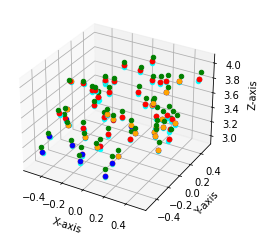

In [29]:
fig_1 = plt.figure()
ax = fig_1.add_subplot(projection='3d')
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
# ax.set_zlim(-3,3)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

for i in range(n):
    ax.scatter( p_c[i][0],  p_c[i][1],  p_c[i][2], c='blue')
    ax.scatter(Xc_1[i][0], Xc_1[i][1], Xc_1[i][2], c='red')
    ax.scatter(Xc_2[i][0], Xc_2[i][1], Xc_2[i][2], c='green')
    ax.scatter(Xc_3[i][0], Xc_3[i][1], Xc_3[i][2], c='cyan')

    ax.scatter(p_c_cv[i][0], p_c_cv[i][1], p_c_cv[i][2], c='orange')
plt.show()

In [30]:
# Calculating pixels
# Case 1
snorm_1 = Xc_1*(1/Xc_1[:,2].reshape((n,1)))
pix_c_1 = snorm_1 @ camera_para.T

snorm_2 = Xc_2*(1/Xc_2[:,2].reshape((n,1)))
pix_c_2 = snorm_2 @ camera_para.T

snorm_3 = Xc_3*(1/Xc_3[:,2].reshape((n,1)))
pix_c_3 = snorm_3 @ camera_para.T

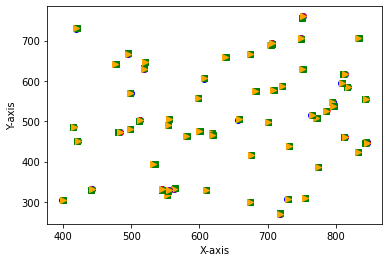

In [31]:
#Plotting points

fig_1 = plt.figure()
ax = fig_1.add_subplot()
# ax.set_xlim(0,u_0*2)
# ax.set_ylim(0,v_0*2)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

for i in range(n):
    ax.scatter(pix_yo[i][0], pix_yo[i][1], c="blue", marker='o')
    ax.scatter(pix_c_1[i,0], pix_c_1[i,1], c="red", marker='p')
    ax.scatter(pix_c_2[i,0], pix_c_2[i,1], c="green", marker='s')
    # ax.scatter(pix_c_3[i,0], pix_c_3[i,1], c="cyan", marker='o')

    ax.scatter(pix_cv[i,0], pix_cv[i,1], c="orange", marker='>')

plt.show()